In [1]:
import matplotlib.pyplot as plt
import numpy as np

N_CITIES = 20  
DNA_SIZE =20
CROSS_RATE = 0.5
MUTATE_RATE = 0.01
POP_SIZE = 500
N_GENERATIONS = 500

X_BOUND = [-5, 5]
Y_BOUND = [-5, 5]

In [31]:
class GA_TSP(object):
    def __init__(self, DNA_size, cross_rate, mutation_rate, pop_size,problem ):
        self.DNA_size = DNA_size
        self.cross_rate = cross_rate
        self.mutate_rate = mutation_rate
        self.pop_size = pop_size
        self.problem=problem
        if self.problem=='TSP':
            self.pop = np.vstack([np.random.permutation(DNA_size) for _ in range(pop_size)])
        if self.problem=='Minimal':
            self.pop = np.random.randint(2, size=(POP_SIZE, DNA_SIZE*2)) 

    def translateDNA(self, DNA, city_position):     # get cities' coord in order
        line_x = np.empty_like(DNA, dtype=np.float64)
        line_y = np.empty_like(DNA, dtype=np.float64)
        if self.problem=='TSP':
            for i, d in enumerate(DNA):
                city_coord = city_position[d]
                line_x[i, :] = city_coord[:, 0]
                line_y[i, :] = city_coord[:, 1]
        if self.problem=='Minimal':
            pop=DNA
            x_pop = pop[:,1::2]#奇数列表示X
            y_pop = pop[:,::2] #偶数列表示y

            #pop:(POP_SIZE,DNA_SIZE)*(DNA_SIZE,1) --> (POP_SIZE,1)
            line_x = x_pop.dot(2**np.arange(DNA_SIZE)[::-1])/float(2**DNA_SIZE-1)*(X_BOUND[1]-X_BOUND[0])+X_BOUND[0]
            line_y = y_pop.dot(2**np.arange(DNA_SIZE)[::-1])/float(2**DNA_SIZE-1)*(Y_BOUND[1]-Y_BOUND[0])+Y_BOUND[0]
        return line_x, line_y

    def get_fitness(self, line_x, line_y):
        if self.problem=='TSP':
            total_distance = np.empty((line_x.shape[0],), dtype=np.float64)
            for i, (xs, ys) in enumerate(zip(line_x, line_y)):
                total_distance[i] = np.sum(np.sqrt(np.square(np.diff(xs)) + np.square(np.diff(ys))))

                #print(line_x)
                #print("total_distance",total_distance[i])
                #print("diffx",line_x[-1]-line_x[0])

                total_distance[i]+=np.sqrt(np.square(line_x[i][-1]-line_x[i][0]) + np.square(line_y[i][-1]-line_y[i][0]))

            #res += self.matrix_distance[one_path[-1],one_path[0]]
            fitness = np.exp(self.DNA_size * 2 / total_distance)
            return fitness, total_distance
        if self.problem=='Minimal':
            pred=F(line_x,line_y)
            fitness=np.exp(pred - np.min(pred)) + 1e-3
            return fitness
        

    def select(self, fitness):
        idx = np.random.choice(np.arange(self.pop_size), size=self.pop_size, replace=True, p=fitness / fitness.sum())
        return self.pop[idx]

    def crossover(self, parent, pop):
        if np.random.rand() < self.cross_rate:
            i_ = np.random.randint(0, self.pop_size, size=1)                        # select another individual from pop
            cross_points = np.random.randint(0, 2, self.DNA_size).astype(np.bool)   # choose crossover points
            keep_city = parent[~cross_points]                                       # find the city number
            swap_city = pop[i_, np.isin(pop[i_].ravel(), keep_city, invert=True)]
            parent[:] = np.concatenate((keep_city, swap_city))
        return parent

    def mutate(self, child):
        for point in range(self.DNA_size):
            if np.random.rand() < self.mutate_rate:
                swap_point = np.random.randint(0, self.DNA_size)
                swapA, swapB = child[point], child[swap_point]
                child[point], child[swap_point] = swapB, swapA
        return child

    def crossover_and_mutation(pop, CROSS_RATE = 0.8):
        new_pop = []
        for father in pop:		#遍历种群中的每一个个体，将该个体作为父亲
            child = father		#孩子先得到父亲的全部基因（这里我把一串二进制串的那些0，1称为基因）
            if np.random.rand() < CROSSOVER_RATE:			#产生子代时不是必然发生交叉，而是以一定的概率发生交叉
                mother = pop[np.random.randint(POP_SIZE)]	#再种群中选择另一个个体，并将该个体作为母亲
                cross_points = np.random.randint(low=0, high=DNA_SIZE*2)	#随机产生交叉的点
                child[cross_points:] = mother[cross_points:]		#孩子得到位于交叉点后的母亲的基因
            mutate(child)	#每个后代有一定的机率发生变异
            new_pop.append(child)

        return new_pop

    def evolve(self, fitness):
        pop = self.select(fitness)
        if self.problem=='TSP':
            
            pop_copy = pop.copy()
            for parent in pop:  # for every parent
                child = self.crossover(parent, pop_copy)
                child = self.mutate(child)
                parent[:] = child
        else:
            pop = np.array(self.crossover_and_mutation(pop))
            fitness = self.get_fitness(pop)
            pop = self.select(pop, fitness) #选择生成新的种群
        self.pop = pop


class TravelSalesPerson(object):
    def __init__(self, n_cities):
        self.city_position = np.random.rand(n_cities, 2) #随机生成城市
        plt.ion()

    def plotting(self, lx, ly, total_d):
        plt.cla()
        plt.scatter(self.city_position[:, 0].T, self.city_position[:, 1].T, s=100, c='k')
        x=self.city_position[:, 0].T
        y=self.city_position[:, 1].T
        for i in range(len(x)):
            plt.annotate(i+1,xy = (x[i], y[i]), xytext = (x[i]+0.01, y[i]+0.01))
        plt.plot(lx.T, ly.T, 'r-')
        plt.plot([lx[-1],lx[0]],[ly[-1],ly[0]],'r')
        plt.text(-0.05, -0.05, "Total distance=%.2f" % total_d, fontdict={'size': 20, 'color': 'red'})
        plt.xlim((-0.1, 1.1))
        plt.ylim((-0.1, 1.1))
        plt.pause(0.01)



In [50]:
def TSP():
    ga = GA_TSP(DNA_size=N_CITIES, cross_rate=CROSS_RATE, mutation_rate=MUTATE_RATE, pop_size=POP_SIZE,problem='TSP')
    distance=[]
    env = TravelSalesPerson(N_CITIES)
    for generation in range(N_GENERATIONS):
        lx, ly = ga.translateDNA(ga.pop, env.city_position)
        fitness, total_distance = ga.get_fitness(lx, ly)
        ga.evolve(fitness)
        best_idx = np.argmax(fitness)
        best_dis=total_distance[best_idx]
        distance.append(best_dis)
        if generation%30==0 or generation==N_GENERATIONS-1:
            print('Gen:', generation, '| best fit: %.2f' % fitness[best_idx],)
        if generation==0 or generation==N_GENERATIONS-1:
            env.plotting(lx[best_idx], ly[best_idx], total_distance[best_idx])

    plt.ioff()
    plt.show()
    # 目标函数变化曲线
    y1=distance
    y2=fitness
    x=list(range(len(distance)))
    plt.plot(x,y1)
    plt.show()

Gen: 0 | best fit: 146.69


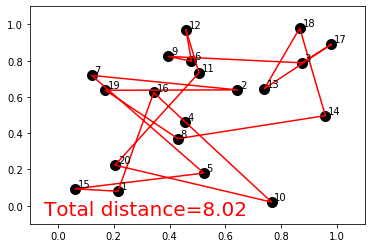

Gen: 30 | best fit: 1009.56
Gen: 60 | best fit: 2080.62
Gen: 90 | best fit: 4182.24
Gen: 120 | best fit: 5533.59
Gen: 150 | best fit: 8495.89
Gen: 180 | best fit: 10252.56
Gen: 210 | best fit: 10252.56
Gen: 240 | best fit: 10252.56
Gen: 270 | best fit: 10252.56
Gen: 300 | best fit: 12192.51
Gen: 330 | best fit: 12192.51
Gen: 360 | best fit: 13842.90
Gen: 390 | best fit: 13842.90
Gen: 420 | best fit: 13842.90
Gen: 450 | best fit: 13842.90
Gen: 480 | best fit: 13842.90
Gen: 499 | best fit: 13842.90


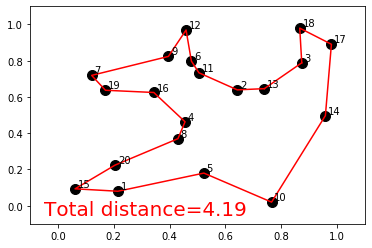

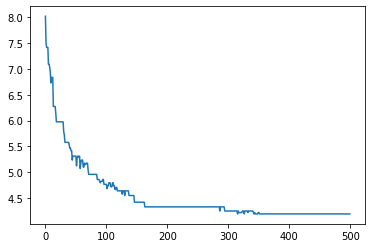

In [8]:
TSP()

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

DNA_SIZE = 24
POP_SIZE = 200
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.005
N_GENERATIONS = 50
X_BOUND = [-3, 3]
Y_BOUND = [-3, 3]


def F(x, y):
	return 3*(1-x)**2*np.exp(-(x**2)-(y+1)**2)- 10*(x/5 - x**3 - y**5)*np.exp(-x**2-y**2)- 1/3**np.exp(-(x+1)**2 - y**2)

def plot_3d(ax):

	X = np.linspace(*X_BOUND, 100)
	Y = np.linspace(*Y_BOUND, 100)
	X,Y = np.meshgrid(X, Y)
	Z = F(X, Y)
	ax.plot_surface(X,Y,Z,rstride=1,cstride=1,cmap=cm.coolwarm)
	ax.set_zlim(-10,10)
	ax.set_xlabel('x')
	ax.set_ylabel('y')
	ax.set_zlabel('z')
	plt.pause(3)
	plt.show()


def get_fitness(pop): 
    x,y = translateDNA(pop)
    pred = F(x, y)
    return -(pred - np.max(pred)) + 1e-3 #防止适应度出现负数

def translateDNA(pop): #pop表示种群矩阵，一行表示一个二进制编码表示的DNA，矩阵的行数为种群数目
	x_pop = pop[:,1::2]#奇数列表示X
	y_pop = pop[:,::2] #偶数列表示y
	
	#pop:(POP_SIZE,DNA_SIZE)*(DNA_SIZE,1) --> (POP_SIZE,1)
	x = x_pop.dot(2**np.arange(DNA_SIZE)[::-1])/float(2**DNA_SIZE-1)*(X_BOUND[1]-X_BOUND[0])+X_BOUND[0]
	y = y_pop.dot(2**np.arange(DNA_SIZE)[::-1])/float(2**DNA_SIZE-1)*(Y_BOUND[1]-Y_BOUND[0])+Y_BOUND[0]
	return x,y

def crossover_and_mutation(pop, CROSSOVER_RATE = 0.8):
	new_pop = []
	for father in pop:		#遍历种群中的每一个个体，将该个体作为父亲
		child = father		#孩子先得到父亲的全部基因（这里我把一串二进制串的那些0，1称为基因）
		if np.random.rand() < CROSSOVER_RATE:			#产生子代时不是必然发生交叉，而是以一定的概率发生交叉
			mother = pop[np.random.randint(POP_SIZE)]	#再种群中选择另一个个体，并将该个体作为母亲
			cross_points = np.random.randint(low=0, high=DNA_SIZE*2)	#随机产生交叉的点
			child[cross_points:] = mother[cross_points:]		#孩子得到位于交叉点后的母亲的基因
		mutation(child)	#每个后代有一定的机率发生变异
		new_pop.append(child)

	return new_pop

def mutation(child, MUTATION_RATE=0.003):
	if np.random.rand() < MUTATION_RATE: 				#以MUTATION_RATE的概率进行变异
		mutate_point = np.random.randint(0, DNA_SIZE)	#随机产生一个实数，代表要变异基因的位置
		child[mutate_point] = child[mutate_point]^1 	#将变异点的二进制为反转

def select(pop, fitness):    # nature selection wrt pop's fitness
    idx = np.random.choice(np.arange(POP_SIZE), size=POP_SIZE, replace=True,
                           p=(fitness)/(fitness.sum()) )
    return pop[idx]

def print_info(pop):
    fitness = get_fitness(pop)
    min_fitness_index = np.argmin(fitness)
    print("min_fitness:", fitness[min_fitness_index])
    x,y = translateDNA(pop)
    print("最优的基因型：", pop[min_fitness_index])
    print("(x, y):", (x[min_fitness_index], y[min_fitness_index]))
    print("最小值：", F(x[min_fitness_index], y[min_fitness_index]))




In [62]:
def GA_Min():
    fig = plt.figure()
    ax = Axes3D(fig)	
    plt.ion()#将画图模式改为交互模式，程序遇到plt.show不会暂停，而是继续执行
    plot_3d(ax)

    pop = np.random.randint(2, size=(POP_SIZE, DNA_SIZE*2)) #matrix (POP_SIZE, DNA_SIZE)
    for _ in range(N_GENERATIONS):#迭代N代
        x,y = translateDNA(pop)
        if 'sca' in locals(): 
            sca.remove()
        sca = ax.scatter(x, y, F(x,y), c='black', marker='o');plt.show();plt.pause(0.1)
        pop = np.array(crossover_and_mutation(pop, CROSSOVER_RATE))
        #F_values = F(translateDNA(pop)[0], translateDNA(pop)[1])#x, y --> Z matrix
        fitness = get_fitness(pop)
        pop = select(pop, fitness) #选择生成新的种群
    
    print_info(pop)
    plt.ioff()
    plot_3d(ax)
    # 目标函数变化曲线
    y1=F(x,y)
    y2=fitness
    x0=list(range(len(y1)))
    plt.plot(x0,y1)
    plt.show()
    plt.plot(x0,y2)
    plt.show()

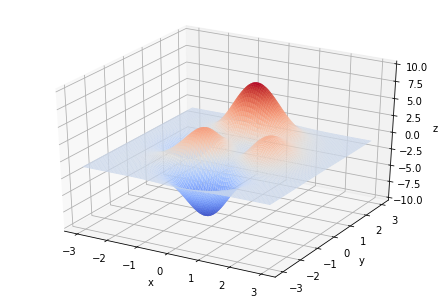

min_fitness: 0.001
最优的基因型： [0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 0 0 0 1 1 1 1 1 0 1 0
 0 0 0 1 1 0 0 0 1 1 1]
(x, y): (0.4874080114011772, -1.7474179713379128)
最小值： -6.695240392869017


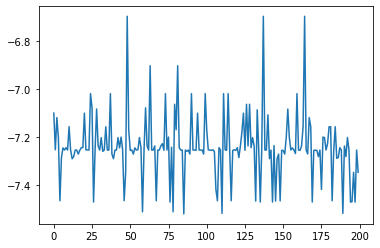

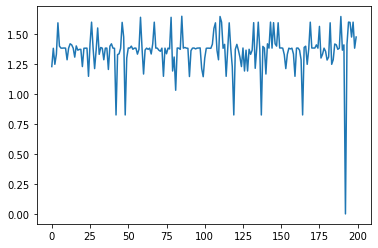

In [63]:
GA_Min()